In [1]:
import matplotlib.pyplot as plt
import torch
import _pickle as pickle
from torchdrug import datasets
import gc

In [2]:
torch.version.cuda

'11.8'

In [3]:
from rdkit.Chem import RDConfig
import os
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import rdmolfiles
from torchdrug.metrics import penalized_logP
from torchdrug.data import Molecule, PackedMolecule
from tqdm import tqdm
from copy import deepcopy
import collections
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import numpy as np
import sascorer
import networkx as nx
import pandas as pd

In [4]:
dataset_num_atom_type=9
dataset_num_bond_type=3
dataset_node_feature_dim=18
dataset_atom_types=[6, 7, 8, 9, 15, 16, 17, 35, 53]

In [7]:
from torchdrug import core, models, tasks

model = models.RGCN(input_dim=dataset_node_feature_dim,
                    num_relation=dataset_num_bond_type,
                    hidden_dims=[256, 256, 256, 256], batch_norm=False)
task = tasks.GCPNGeneration(model, dataset_atom_types, max_edge_unroll=12,
                            max_node=38, criterion="nll")

In [8]:
import os
if torch.cuda.is_available():
    task=task.cuda()
else:
    print("CUDA not available!!?")

#checkpoint = os.path.expanduser("./gcpn_zinc250k_10epoch_mar25_nll_uAhdH9o9h28as2DS21eo8.pkl")
checkpoint = os.path.expanduser("../LearnTorchDrug/gcpn_zinc250k_10epoch_2.pkl")
if torch.cuda.is_available():
    state = torch.load(checkpoint, map_location="cuda")
else:
    state = torch.load(checkpoint, map_location="cpu")
for k in task.load_state_dict(state["model"], strict=False).unexpected_keys:
    print("encountered unexpected key",k)
    task.register_buffer(k,state["model"][k])

encountered unexpected key moving_baseline


In [ ]:
LearnTorchDrug/gcpn_zinc250k_10epoch_2.pkl

In [ ]:
zinc=

In [6]:
gen=task.generate(10_000,15, empty_cache_period=1)

07:43:06   17 / 10000 molecules are invalid even after 15 resampling
07:44:09   1 / 9949 molecules are invalid even after 15 resampling
07:45:02   1 / 9799 molecules are invalid even after 15 resampling
07:45:29   1 / 9672 molecules are invalid even after 15 resampling
07:46:01   1 / 9463 molecules are invalid even after 15 resampling
07:47:22   1 / 8187 molecules are invalid even after 15 resampling
07:47:46   1 / 7487 molecules are invalid even after 15 resampling
07:48:43   1 / 4219 molecules are invalid even after 15 resampling
07:48:56   1 / 3574 molecules are invalid even after 15 resampling
07:49:07   1 / 2978 molecules are invalid even after 15 resampling
07:49:16   1 / 2461 molecules are invalid even after 15 resampling
07:49:25   1 / 2008 molecules are invalid even after 15 resampling
07:49:43   1 / 785 molecules are invalid even after 15 resampling


In [9]:
smiles=gen.to_smiles()

In [10]:
len(set(smiles)),len(smiles)

(14, 10000)

In [11]:
gen

PackedMolecule(batch_size=10000, num_atoms=[6, 6, 6, ..., 7, 7, 7], num_bonds=[10, 10, 10, ..., 12, 12, 12], device='cuda:0')

In [7]:
rdmols=gen.to_molecule()

In [49]:
lpgen2_rdk = pd.Series([Descriptors.MolLogP(mol) for mol in rdmols],name="logp")

In [140]:
zinc_metr=pd.read_csv("ZINC_10K_metrics.csv")

In [141]:
zinc_metr['logp_torchdrug'].describe()

count    10000.000000
mean         2.471348
std          1.445061
min         -5.211200
25%          1.590325
50%          2.612700
75%          3.507350
max          7.361100
Name: logp_torchdrug, dtype: float64

In [9]:
def get_metrics(smiles=None,mols=None):
    if not isinstance(smiles, collections.abc.Iterable) and not isinstance(mols, collections.abc.Iterable):
        raise Exception("must provide smiles: list[str] or mols: list[rdkit-mol]")
    if not isinstance(mols, collections.abc.Iterable):
        mols = PackedMolecule.from_smiles(smiles).to_molecule()
    else:
        mols = deepcopy(mols)
    if not isinstance(smiles, collections.abc.Iterable):
        smiles = [Chem.MolToSmiles(m) for m in mols]

    mwt=[].copy()
    logp=[].copy()
    qed=[].copy()
    hbaNO=[].copy()
    hbdNHOH=[].copy()
    plogp=[].copy()
    hac=[].copy()
    sascore=[].copy()
    cycle_score=[].copy()
    iterator=tqdm(zip(mols,smiles),total=len(mols))
    for mol,s in iterator:
        logp.append(Descriptors.MolLogP(mol))
        qed.append(QED.qed(mol))
        mwt.append(Descriptors.ExactMolWt(mol))
        hbdNHOH.append(Descriptors.NumHDonors(mol))
        plogp.append(float(penalized_logP(Molecule.from_smiles(s)).mean()))
        hac.append(Descriptors.HeavyAtomCount(mol))

        cycle_list = nx.cycle_basis(nx.Graph(Chem.rdmolops.GetAdjacencyMatrix(mol)))
        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([len(j) for j in cycle_list])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6
        cycle_score.append(-cycle_length)
    
        
        Chem.SanitizeMol(mol)
        sascore.append(sascorer.calculateScore(mol))
        hbaNO.append(Descriptors.NumHAcceptors(mol))

    return pd.DataFrame({
        "smiles":smiles,
        "mwt":mwt,
        "logp_rdkit":logp,
        "qed":qed,
        "sascore":sascore,
        "hba(NO)":hbaNO,
        "hbd(NHOH)":hbdNHOH,
        "plogp":plogp,
        "cycle_score":cycle_score,
        "heavy_atom_count":hac,
    })

In [10]:
zinc10k=pd.read_csv("zinc_250k_10k.csv")
gcpn_250k=pd.read_csv("gcpn_250k_10k.csv")

In [11]:
gcpn_old_ft=pd.read_csv("gcpn_old_ft.csv")

In [12]:
gcpn_old_pt=get_metrics(mols=rdmols)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 9971/9971 [03:53<00:00, 42.72it/s]


In [13]:
gcpn_old_pt.to_csv("gcpn_old_pt.csv",index=False)

mwt
zinc10k
gcpn new
gcpn old pt
gcpn old


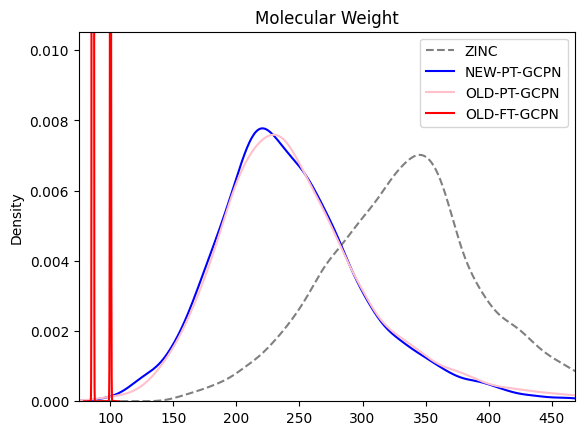

logp_rdkit
zinc10k
gcpn new
gcpn old pt
gcpn old


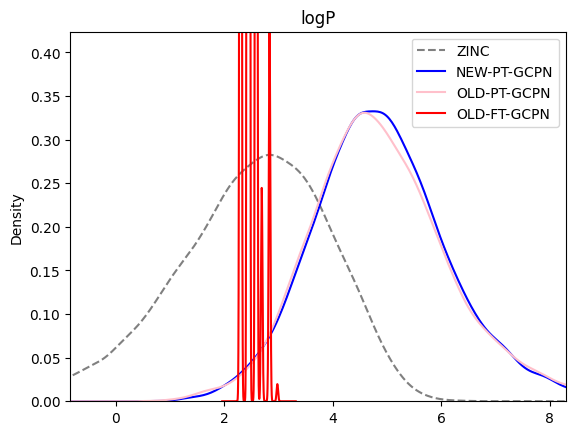

qed
zinc10k
gcpn new
gcpn old pt
gcpn old


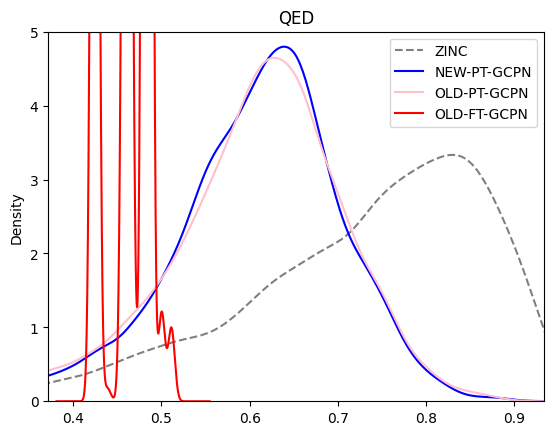

sascore
zinc10k
gcpn new
gcpn old pt
gcpn old


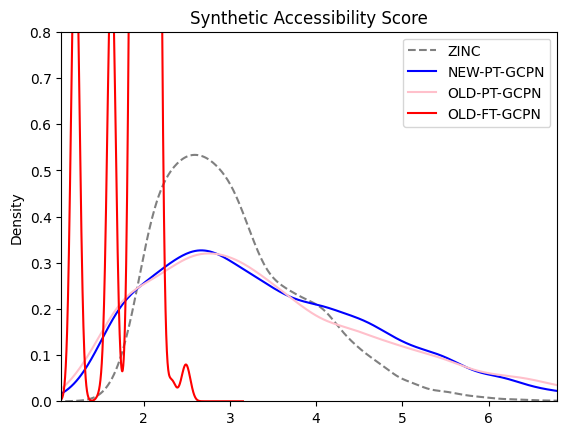

plogp
zinc10k
gcpn new
gcpn old pt
gcpn old


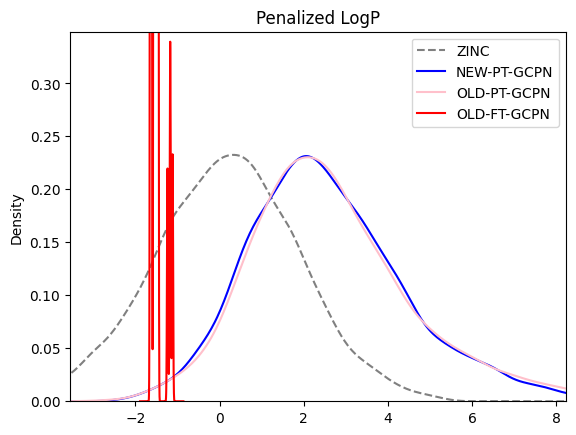

cycle_score
zinc10k
gcpn new
gcpn old pt
gcpn old


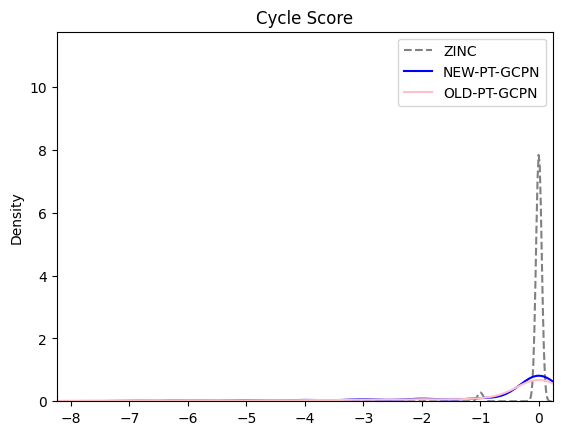

In [17]:
%matplotlib inline
trans={
    'mwt':'Molecular Weight',
    'logp_rdkit':'logP',
    'qed':'QED',
    'sascore':'Synthetic Accessibility Score',
    'plogp':'Penalized LogP',
    'cycle_score':'Cycle Score',
}
for col in ('mwt', 'logp_rdkit', 'qed', 'sascore', 'plogp', 'cycle_score'):
    C=0.03
    print(col)
    ax=zinc10k[col].plot.kde(c='grey', linestyle="--")
    lines = ax.get_lines()
    x1, y1 = lines[0].get_data()
    min_=zinc10k[col].quantile(C)
    max_=zinc10k[col].quantile(1-C)
    print("zinc10k")
    ax=gcpn_250k[col].plot.kde(c='b')
    lines = ax.get_lines()
    x2, y2 = lines[0].get_data()
    min_=min(min_,gcpn_250k[col].quantile(C))
    max_=max(max_,gcpn_250k[col].quantile(1-C))
    print("gcpn new")
    ax=gcpn_old_pt[col].plot.kde(c='pink')
    lines = ax.get_lines()
    x3, y3 = lines[0].get_data()
    min_=min(min_,gcpn_old_pt[col].quantile(C))
    max_=max(max_,gcpn_old_pt[col].quantile(1-C))
    print("gcpn old pt")
    x4=[].copy()
    y4=[].copy()
    if col!="cycle_score":
        ax=gcpn_old_ft[col].plot.kde(c='r')
        lines = ax.get_lines()
        x4, y4 = lines[0].get_data()
        min_=min(min_,gcpn_old_ft[col].quantile(C))
        max_=max(max_,gcpn_old_ft[col].quantile(1-C))
    print("gcpn old")
    ypds=pd.Series(np.concatenate([y1,y2,y3,y4]))
    plt.title(trans[col])
    plt.legend(["ZINC","NEW-PT-GCPN","OLD-PT-GCPN","OLD-FT-GCPN"])
    plt.ylim(0,max(max(y1.max(),y2.max()),y3.max())*1.5)
    plt.xlim(min_-(max_-min_)*C,max_+(max_-min_)*C)
    plt.show()

In [100]:
def 

<bound method _AxesBase.get_xlim of <Axes: ylabel='Density'>>

In [95]:
gcpn_250k['mwt'].quantile(0.04)

152.15650064

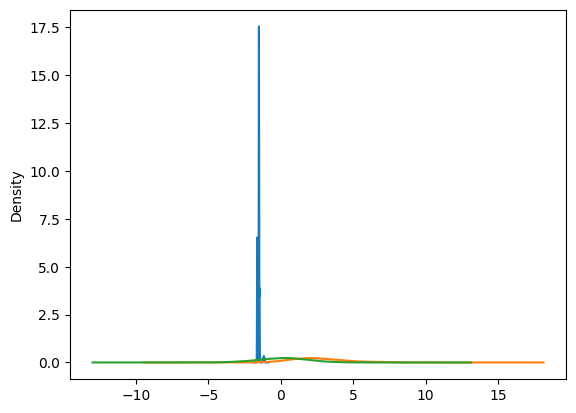

In [118]:
ax=gcpn_old_ft['plogp'].plot.kde()
lines = ax.get_lines()
x1, y1 = lines[0].get_data()
ax=gcpn_250k['plogp'].plot.kde()
lines = ax.get_lines()
x2, y2 = lines[0].get_data()
ax=zinc10k['plogp'].plot.kde()
lines = ax.get_lines()
x3, y3 = lines[0].get_data()


<Axes: ylabel='Density'>

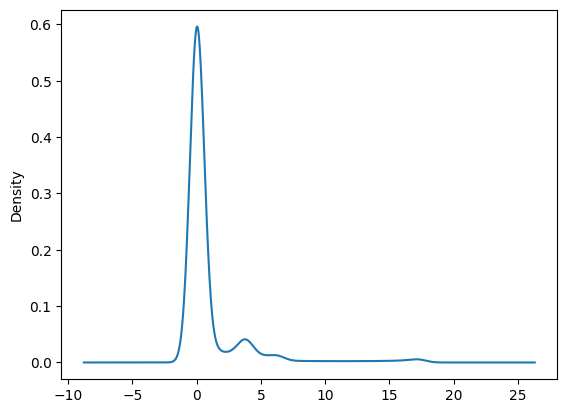

In [120]:
pd.Series(np.concatenate([y1,y2,y3])).plot.kde()

In [124]:
pd.Series(np.concatenate([y1,y2,y3])).quantile(0.8)

0.3100923216966792

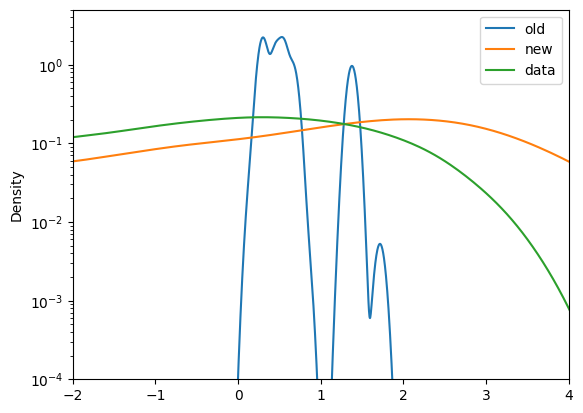

In [86]:
(gcpn_old_ft['logp_rdkit']-gcpn_old_ft['sascore']+gcpn_old_ft['cycle_score']).plot.kde()
(gcpn_250k['logp_rdkit']-gcpn_250k['sascore']+gcpn_250k['cycle_score']).plot.kde()
ax=(zinc10k['logp_rdkit']-zinc10k['sascore']+zinc10k['cycle_score']).plot.kde()
plt.legend(['old','new','data'])
plt.xlim(-2,4)
plt.ylim(10e-5,5)
plt.yscale('log')


<Axes: ylabel='Density'>

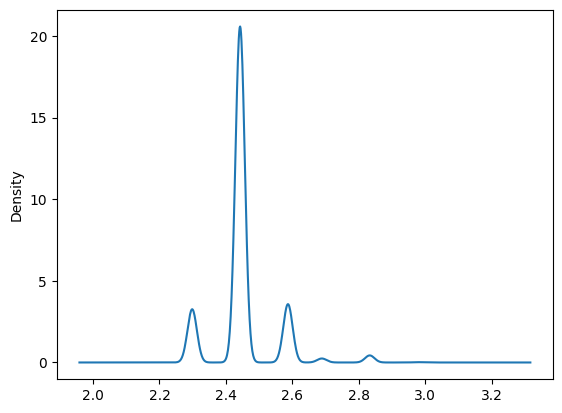

In [47]:
gcpn_old_ft['logp_rdkit'].plot.kde()

In [239]:
dir(nx)

['AmbiguousSolution',
 'ArborescenceIterator',
 'DiGraph',
 'EdgePartition',
 'ExceededMaxIterations',
 'Graph',
 'GraphMLReader',
 'GraphMLWriter',
 'HasACycle',
 'LCF_graph',
 'LFR_benchmark_graph',
 'MultiDiGraph',
 'MultiGraph',
 'NetworkXAlgorithmError',
 'NetworkXError',
 'NetworkXException',
 'NetworkXNoCycle',
 'NetworkXNoPath',
 'NetworkXNotImplemented',
 'NetworkXPointlessConcept',
 'NetworkXTreewidthBoundExceeded',
 'NetworkXUnbounded',
 'NetworkXUnfeasible',
 'NodeNotFound',
 'NotATree',
 'PlanarEmbedding',
 'PowerIterationFailedConvergence',
 'SpanningTreeIterator',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_dispatch',
 '_lazy_import',
 'adamic_adar_index',
 'add_cycle',
 'add_path',
 'add_star',
 'adjacency',
 'adjacency_data',
 'adjacency_graph',
 'adjacency_matrix',
 'adjacency_spectrum',
 'adjlist',
 'algebraic_connectivity',
 'algebraicconnectivity',
 'algorithms',
 

In [236]:
gcpn_metrics.sort_values("qed",ascending=False).head()

,smiles,mwt,logp_rdkit,qed,sascore,hba(NO),hbd(NHOH),plogp,heavy_atom_count
8518,CC(=CC1=CC=CC2=CCCC=C12)NC(=O)CC1=CC=CC=C1,303.162314,4.5917,0.924362,2.833726,1,1,3.063634,23
6315,CC1=CC(C)=CC(CNC(=O)C2=CC=CC(C)=C2C)=C1,267.162314,3.7678,0.898834,1.718192,1,1,1.736345,20
8264,CCC(C)CC=C1C2=CC=CC=C1C1=CC=CC(=C1)NC(C)=C2,303.198700,5.6587,0.890351,5.506081,0,1,3.808283,23
7516,CC1=CC=CC=C1C1=CC=CC(C(=O)NC2CCCC2)=C1,279.162314,3.9103,0.889627,1.652867,1,1,2.251563,21
6286,CC1=C(C2=CC=CC=C2)C(C(=O)NCC(C)C)=CC=C1,267.162314,3.6237,0.889343,1.712521,1,1,1.783886,20


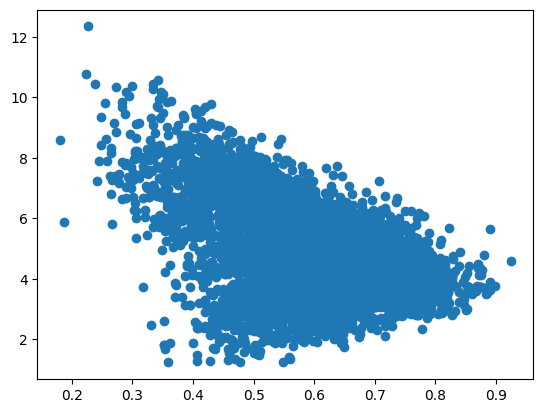

In [181]:
plt.scatter(gcpn_metrics['qed'],gcpn_metrics['logp_rdkit'])

In [211]:
#x,y=(zinc10k['qed'],zinc10k['logp_rdkit'])
def plot_kde(x,y):
    from scipy.stats import gaussian_kde
    import numpy as np

    fig,ax=plt.subplots()
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    
    # Define the grid over which to evaluate the KDE
    x_grid = np.linspace(x.min(), x.max(), 100)
    y_grid = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Evaluate the KDE on the grid
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
    
    # Plot the KDE
    ax.imshow(np.rot90(Z.reshape(X.shape)), cmap=plt.cm.gist_earth_r,
               extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    
    current_width = fig.get_figwidth()
    #fig.set_figwidth(current_width * 20)
    return fig,ax

Text(0.5, 1.0, 'dataset ZINC')

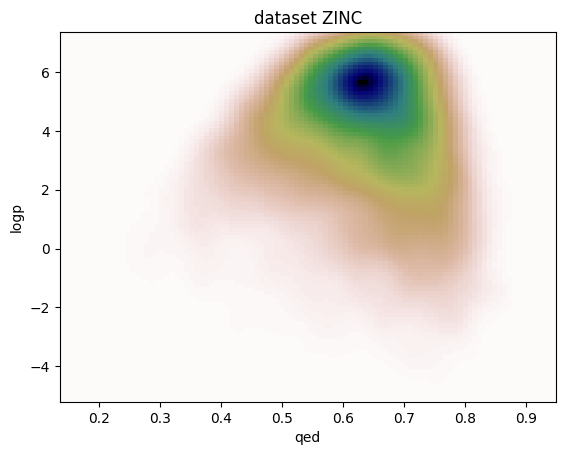

In [214]:
fig,ax=plot_kde(zinc10k['qed'],zinc10k['logp_rdkit'])
plt.xlabel("qed")
plt.ylabel("logp")
plt.title("dataset ZINC")

Text(0, 0.5, 'logp')

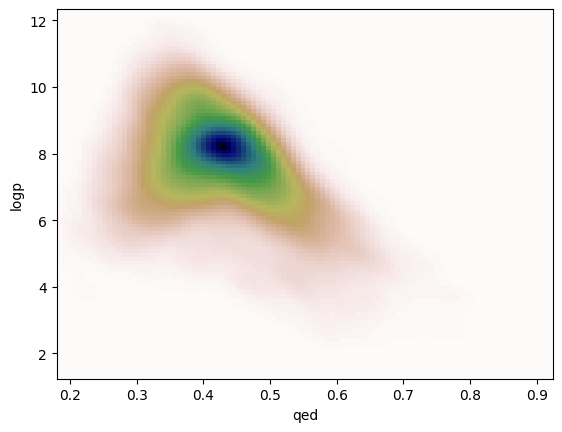

In [213]:
fig,ax=plot_kde(gcpn_metrics['qed'],gcpn_metrics['logp_rdkit'])
plt.xlabel("qed")
plt.ylabel("logp")

In [179]:
zinc10k.sort_values("qed",ascending=False).head()

,smiles,mwt,logp_rdkit,qed,hba(NO),hbd(NHOH),plogp,heavy_atom_count
8207,CC1=CC=C([C@@H](CO)[C@@H]2CS(=O)(=O)C3=CC=CC=C...,302.097665,2.64202,0.948051,3,1,-0.688839,21
8375,CN1N=CC(NC[C@H]2CCCC3=CC=CC=C32)=C(Cl)C1=O,303.113840,2.96570,0.948048,4,1,0.779070,21
1965,CC1=CN=C(NC(=O)[C@H]2CC(C3=CC=CC(F)=C3)=NO2)S1,305.063426,2.72232,0.948033,5,1,-0.747646,21
6891,COC1=CC(Cl)=C(C)C=C1NC(=O)C1=CN(C)C(=O)C=C1,306.077120,2.60802,0.947947,4,1,-0.279985,21
4718,CC1=CNN=C1[C@H]1CCCCN1C(=O)C1=CC=NN1C(C)C,301.190260,2.86292,0.947593,4,1,0.340061,22


In [104]:
for k,v in gcpn_metrics.items():
    print(k,len(v))

smiles 0
logp 9979
qed 9979
hbaNO 9979
hbdNHOH 9979
plogp 9979
hac 9979


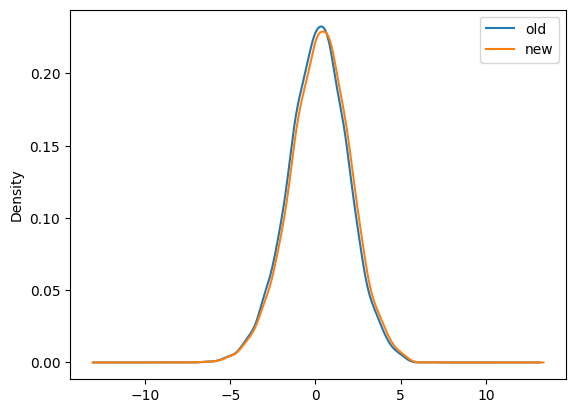

In [215]:
zinc10k['plogp'].plot.kde()
zinc_metr['plogp'].plot.kde()
plt.legend(['old','new'])

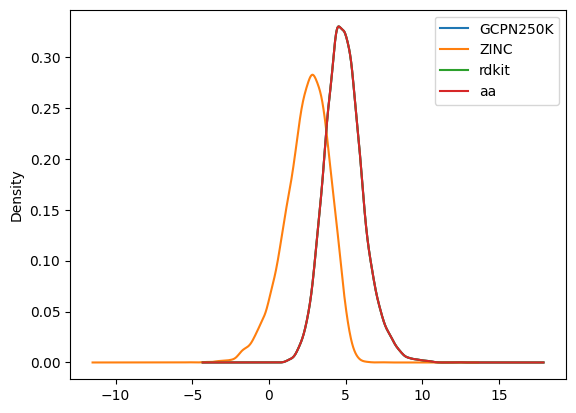

In [110]:
%matplotlib inline
lpgen2_td_pds.plot.kde()
zinc_metr['logp_torchdrug'].plot.kde()
lpgen2_rdk.plot.kde()
gcpn_metrics['logp'].plot.kde()
plt.legend(['GCPN250K','ZINC','rdkit','aa'])

In [30]:
zinc_metr['logp_torchdrug'].describe()

count    10000.000000
mean         2.471348
std          1.445061
min         -5.211200
25%          1.590325
50%          2.612700
75%          3.507350
max          7.361100
Name: logp_torchdrug, dtype: float64

In [33]:
logps.plot.kde()
plt.title("distribusi Log-P model GCPN 250K 10Epoch\n(pretrained non-finetuned)")
print(f"mean={logps.mean()}")
print(f"std={logps.std()}")

NameError: name 'logps' is not defined

In [26]:
results = task.generate(num_sample=32, max_resample=15)
print(results.to_smiles())

['C=S(C)C1(CC)CCC(C)C1', 'CCC(CC)(CCCO)C(C)C', 'CC1CCCCC(C)OC(=O)C1', 'C=CC1C2=CC=CC=C2C2CCC12', 'C1=CC=C(CCC2=CC=CC=N2)C=C1', 'C=CC(CC)C1=CC=CC2=CC=C1C=C2', 'CN(C1=CC=CC(Br)=C1)C1=CC=CC=C1Cl', 'CC1=CC(C)=CC(C2=C(Cl)C=CC=C2C)=C1', 'CC1=CC=CC(C(=O)NC2CCNC(C)C2)=N1', 'CC1CCC(CC(C)C(C)C)N2C=C(C=N2)C1', 'CC(=O)C1=CC=C(C(C)NC(=O)CC(C)C)C=C1', 'CC(C1=CC=CC=C1)N(C)CC1=CC=CC=C1', 'CCC(OCCN1C=CC=C1)C1=CC=CC=C1', 'CC1CCC2=C(C=C(C3=CC=C(Br)C=C3)S2)C1', 'CC(=O)C1=CC(=C2C=N2)C(CCN(C)C)=CC=C1', 'C=C1C2=CC=CC=CC(=C2)C2=CC=C(OC)C1=C2', 'CC=S1C=CC=C(C)C=C2C(C=C(C)O)=CC=C1C2C', 'CN(CCCC1=CC=NC=C1Br)CC1=CC=CC(F)=C1', 'CC(NCC1=CC=C(C2=CC=CC=C2)C=C1)C1CC1', 'CCCC(CC)N1C2=CC=CC=C2C2=C1C=CC(=O)C2', 'CC1(C)CC2=C(C=CC=C1C=CCl)NC1=CC=CC=C12', 'CC1=NC(C2=C3C=C(C=CC(C4=CC=CS4)=C3)O2)=NO1', 'CCC(N)C(=O)NCC12CC3=CC=CC=C3C1=CC1CC12', 'COC1=CC(C(CC(=O)NC(C)C)NC2=CC=CC=C2)=CC=C1O', 'COC1=CC=CC=C1N(C)C(CC1=CC=CC=C1)=C(C)C=C(C)S', 'COC1=CC=CC=CC2=CC=NCC3=CC(=CC=C3C1=C(C)O)C#C2', 'CCCNC=CC=C1C2=CC(=O)CCC(CC1C)C2C1=CC=CC=

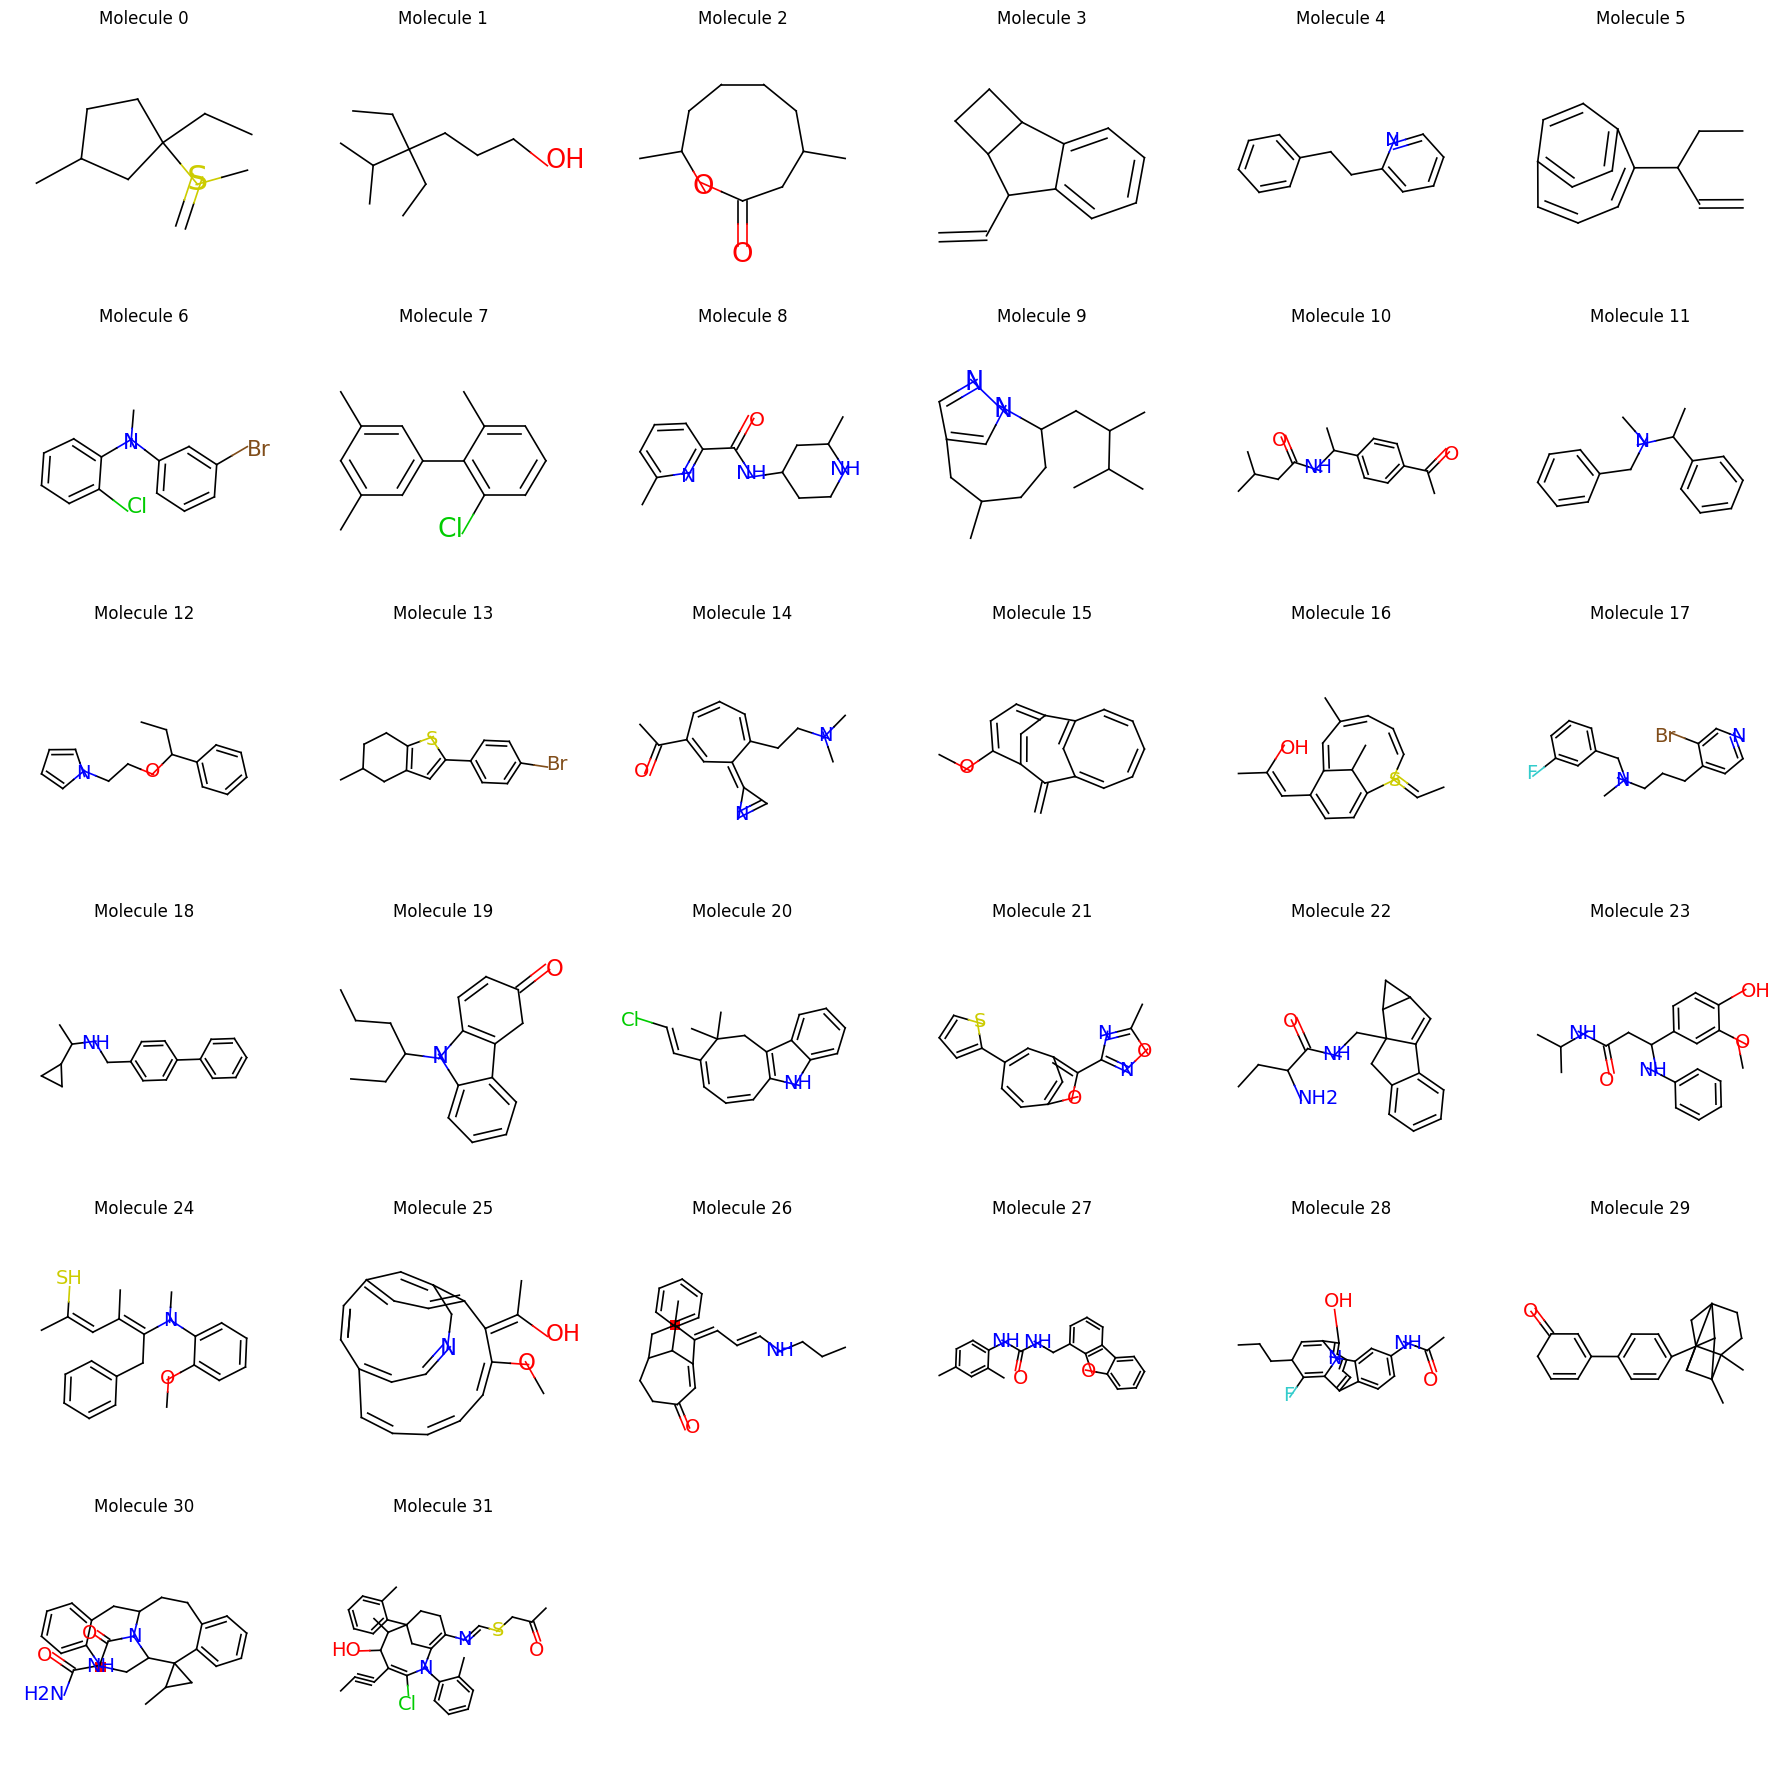

In [27]:
from torchdrug.data import PackedMolecule

mols=PackedMolecule.from_smiles(results.to_smiles())
_=mols.visualize()